# 基于Faster R-CNN的目标识别
之前我们已经处理过了目标分类问题，其任务是对于给定的图像预测出其类别，或者说预测某个目标**在图像中是否存在**。而在目标识别问题中，我们不仅关心我们需要检测的目标是否存在，我们还希望得到它在图像当中的位置。

In [37]:
from torchvision import models
from PIL import Image
import torchvision.transforms as T
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

COCO_INSTANCE_CATEGORY_NAMES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [3]:
# Load 
fasterRCNN = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
fasterRCNN.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\MK9/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100.0%


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [34]:
img = Image.open('./raw/faster_rcnn/people.jpg')
trf = T.ToTensor()
img = trf(img)
box, cate = get_pred(fasterRCNN, './raw/faster_rcnn/people.jpg', 0.6)

In [42]:
cate[]

'person'

In [22]:
def get_pred(model, img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model(img.unsqueeze(0))
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())
    
    # Scores are arranged in descending order, so keep the scores before the last one that is above threshold
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

In [51]:
# Pipeline to get the input image and output result
def object_detection_api(img_path, model, th=0.5, rect_th=3, text_size=3, text_th=3):
    boxes, pred_cls = get_pred(model, img_path, th)
    boxes = np.array(boxes).astype(np.uint)
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    for i in range(len(boxes)):
        cv.rectangle(img, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=rect_th)
        cv.putText(img, pred_cls[i], boxes[i][0], cv.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
    
    plt.figure(figsize=(20, 30))
    plt.imshow(img)
    plt.axis('off')

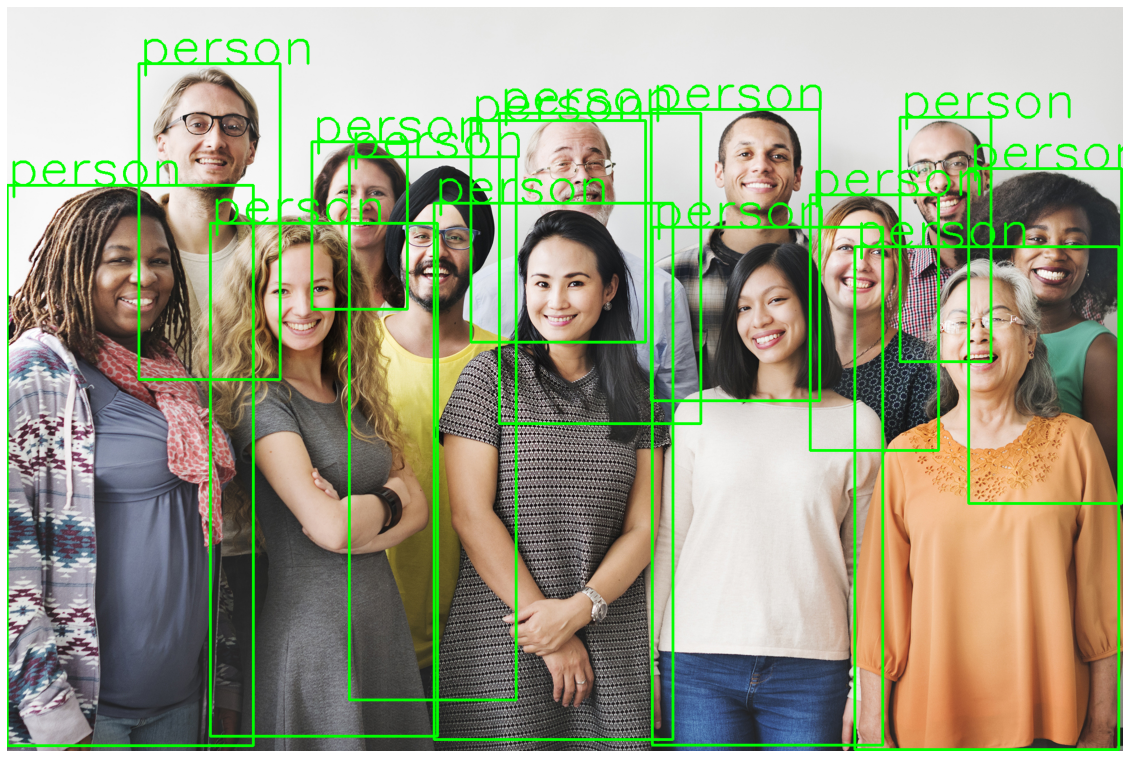

In [52]:
img_path = './raw/faster_rcnn/people.jpg'
object_detection_api(img_path, fasterRCNN)